# Parkinson's data exploration

## Imports

In [85]:
from datasets import load_dataset, Audio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import soundfile
import torchcodec
import IPython.display as ipd
import librosa
import librosa.display
import os
from pathlib import Path
from glob import glob
from scipy.io import wavfile
import parselmouth
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences


## Dataset exploration

#### Loading the dataset from huggingface

Dataset used: Giovanni Dimauro, Francesco Girardi, "Italian Parkinson's Voice and Speech", IEEE Dataport, June 11, 2019, doi:10.21227/aw6b-tg17

In [ ]:
#Loading huggingface birgermoell/Italian_Parkinsons_Voice_and_Speech dataset
ds = load_dataset("birgermoell/Italian_Parkinsons_Voice_and_Speech")
ds

Possible requirements for the dataset:
- pip install datasets
- pip install soundfiles
- brew install ffmpeg
- pip install torchcodec
- pip install librosa
- pip install praat-parselmouth

In [ ]:
#1st file
ds['train'][0]

In [ ]:
#1st audio
audio_0 = ds['train'][0]['audio']
audio_0

This is a lazy decoder object from torchcodec. Audio is not loaded yet.

In [ ]:
audio_0['array']

##### Play an audio file

In [ ]:
#Playing the 1st audio file with IPython display

print(f"Sample rate: {audio_0['sampling_rate']} Hz")
ipd.Audio(audio_0["array"], rate=audio_0["sampling_rate"])

In [ ]:
#Playing another audio file with IPython display

audio_n = ds['train'][500]['audio']

print(f"Sample rate: {audio_n['sampling_rate']} Hz")
ipd.Audio(audio_n["array"], rate=audio_n["sampling_rate"])

##### Visualize waveform

In [ ]:
# Extract 1st audio data and sampling rate
waveform = audio_0["array"]
sample_rate = audio_0["sampling_rate"]

# Create time axis in seconds
time_axis = [i / sample_rate for i in range(len(waveform))]

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(time_axis, waveform)
plt.title("Waveform of 1st audio file")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

In [ ]:
#Extracting the audios as numpy arrays
files = ds["train"]
audio_arrays = [i['audio']['array'] for i in files]

In [ ]:
len(audio_arrays)

I can't easily classify the audio arrays as there are no labels against them. Changing stragety: downloading the dataset into raw_data folder and loading the dataset from there.

#### Loading the dataset from raw_data folder

In [12]:
#Path to Parkinson's files in raw_data folder
root_dir = "../raw_data/Italian Parkinson's Voice and Speech"

In [14]:
##Create a pd DataFrame with Parkinson's disease classification label (0=healty, 1=Parkinson's)

# Map condition folders to labels
folder_to_label = {
    "15 Young Healthy Control": 0,
    "22 Elderly Healthy Control": 0,
    "28 People with Parkinson's disease": 1
}

data = []

for condition_folder, label in folder_to_label.items():
    condition_path = os.path.join(root_dir, condition_folder)

    if not os.path.exists(condition_path):
        print(f"Skipping missing folder: {condition_path}")
        continue

    # Special case for Parkinson's: one more level deep
    if condition_folder == "28 People with Parkinson's disease":
        # Go through "1-5", "6-10", etc.
        for range_folder in os.listdir(condition_path):
            range_path = os.path.join(condition_path, range_folder)
            if not os.path.isdir(range_path):
                continue
            for subject_folder in os.listdir(range_path):
                subject_path = os.path.join(range_path, subject_folder)
                if not os.path.isdir(subject_path):
                    continue
                wav_files = glob(os.path.join(subject_path, "*.wav"))
                for wav in wav_files:
                    data.append({
                        "filepath": wav,
                        "subject": subject_folder,
                        "group": condition_folder,
                        "label": label
                    })

    else:
        # For healthy controls: subject folders directly inside
        for subject_folder in os.listdir(condition_path):
            subject_path = os.path.join(condition_path, subject_folder)
            if not os.path.isdir(subject_path):
                continue
            wav_files = glob(os.path.join(subject_path, "*.wav"))
            for wav in wav_files:
                data.append({
                    "filepath": wav,
                    "subject": subject_folder,
                    "group": condition_folder,
                    "label": label
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Sanity check
print(f"Found {len(df)} .wav files")
print(df['group'].value_counts())


Found 831 .wav files
group
28 People with Parkinson's disease    437
22 Elderly Healthy Control            349
15 Young Healthy Control               45
Name: count, dtype: int64


In [15]:
df.sample(5)

filepath     subject  \
572  ../raw_data/Italian Parkinson's Voice and Spee...  Domenico C   
540  ../raw_data/Italian Parkinson's Voice and Spee...    Nicola S   
416  ../raw_data/Italian Parkinson's Voice and Spee...   Roberto R   
603  ../raw_data/Italian Parkinson's Voice and Spee...   Roberto R   
525  ../raw_data/Italian Parkinson's Voice and Spee...       Ugo B   

                                  group  label  
572  28 People with Parkinson's disease      1  
540  28 People with Parkinson's disease      1  
416  28 People with Parkinson's disease      1  
603  28 People with Parkinson's disease      1  
525  28 People with Parkinson's disease      1

#### Exploring audio file from a Parkinson's patient

In [21]:
#Select an random file from the subjects with Parkison's
sample = df[df['label'] == 1].sample(1).iloc[0]

# Play the audio directly
print(f"Playing audio from {sample['subject']}: {sample['filepath'].split('/')[-1]}")
ipd.Audio(filename=sample['filepath'])

Playing audio from Vito S: VA1VSIOTLOP47M100220171331.wav


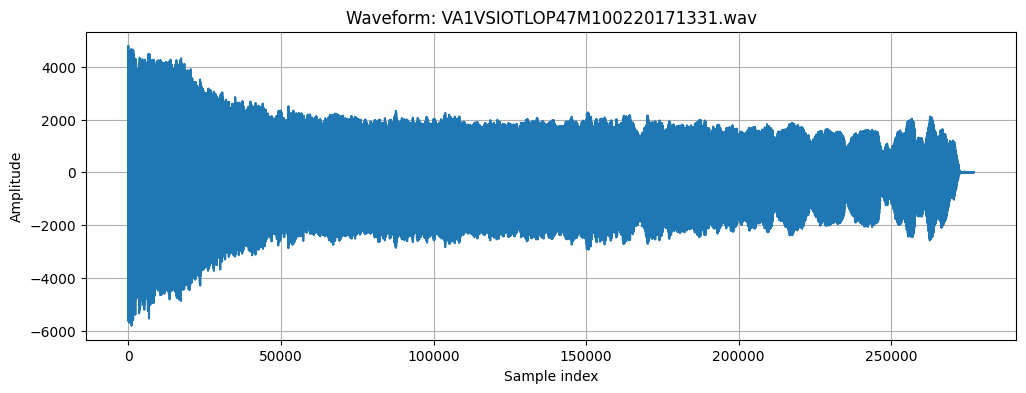

In [22]:
##Plotting the waveform for sample audio

# Read the audio data
sample_rate, audio_data = wavfile.read(sample['filepath'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title(f"Waveform: {sample['filepath'].split('/')[-1]}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)

Text(0.5, 1.0, 'Spectrogram')

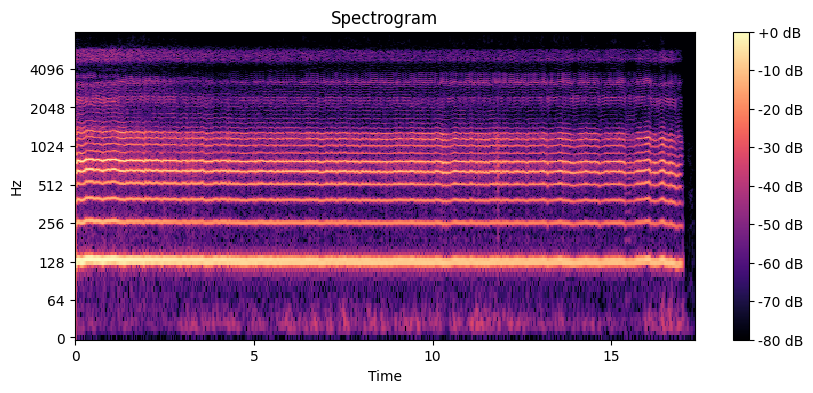

In [23]:
##Spectrogram

# Load audio (returns float32 format)
y, sr = librosa.load(sample['filepath'], sr=None)

# Display spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

#### Exploring audio file from a healthy individual

In [27]:
#Select an random file from healthy subjects
sample_2 = df[df['label'] == 0].sample(1).iloc[0]

# Play the audio directly
print(f"Playing audio from {sample_2['subject']}: {sample_2['filepath'].split('/')[-1]}")
ipd.Audio(filename=sample_2['filepath'])

Playing audio from GILDA C: B1GCIALSDA52F170320171124.wav


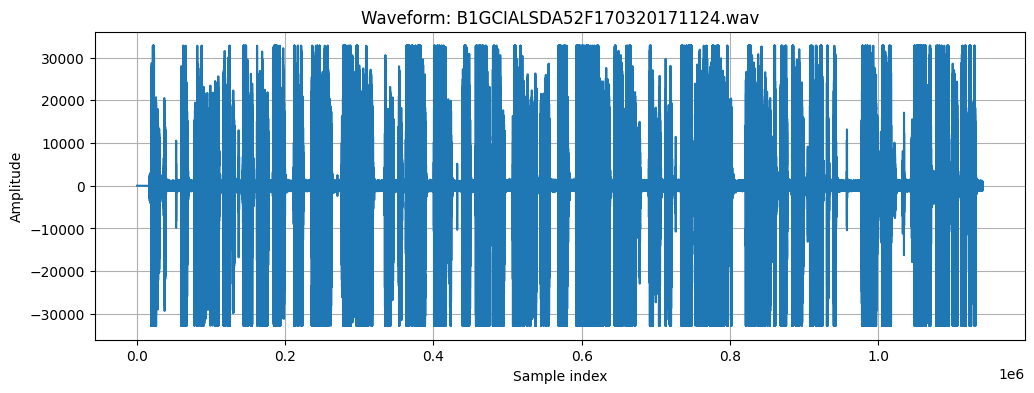

In [28]:
##Plotting the waveform for sample audio

# Read the audio data
sample_rate, audio_data = wavfile.read(sample_2['filepath'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title(f"Waveform: {sample_2['filepath'].split('/')[-1]}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)

Text(0.5, 1.0, 'Spectrogram')

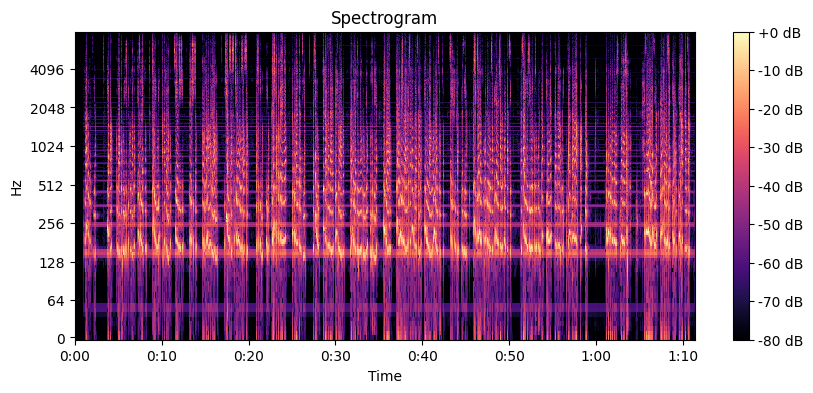

In [29]:
##Spectrogram

# Load audio (returns float32 format)
y, sr = librosa.load(sample_2['filepath'], sr=None)

# Display spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

#### Extracting features from audio

In [30]:
def extract_voice_features(file_path):
    snd = parselmouth.Sound(file_path)

    pitch = snd.to_pitch()
    mean_pitch = pitch.selected_array['frequency'][pitch.selected_array['frequency'] > 0].mean()

    point_process = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)

    jitter = parselmouth.praat.call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)

    shimmer = parselmouth.praat.call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    hnr = parselmouth.praat.call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    mean_hnr = parselmouth.praat.call(hnr, "Get mean", 0, 0)

    return {
        "mean_pitch": mean_pitch,
        "jitter": jitter,
        "shimmer": shimmer,
        "hnr": mean_hnr
    }

In [31]:
feature_list = []
for idx, row in df.iterrows():
    try:
        features = extract_voice_features(row['filepath'])
        features['label'] = row['label']  # Add target if available
        features['filename'] = row['filepath'].split('/')[-1]
        features['subject'] = row['subject']
        feature_list.append(features)
    except Exception as e:
        print(f"Error processing {row['filepath']}: {e}")

features_df = pd.DataFrame(feature_list)

In [32]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pitch  831 non-null    float64
 1   jitter      831 non-null    float64
 2   shimmer     831 non-null    float64
 3   hnr         831 non-null    float64
 4   label       831 non-null    int64  
 5   filename    831 non-null    object 
 6   subject     831 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 45.6+ KB


In [33]:
features_df

mean_pitch    jitter   shimmer        hnr  label  \
0    131.527444  0.026996  0.132367  12.019772      0   
1    117.724878  0.034251  0.169478   8.854039      0   
2    217.812372  0.038597  0.197212   6.832119      0   
3    119.841867  0.036121  0.110967   8.403389      0   
4    117.590166  0.032860  0.108852   8.736543      0   
..          ...       ...       ...        ...    ...   
826  155.192650  0.023594  0.074333  16.690465      1   
827  151.715521  0.021709  0.069693  17.829852      1   
828  278.124654  0.014055  0.045229  18.045575      1   
829  219.855682  0.018370  0.103703  14.818904      1   
830  156.151309  0.025482  0.071094  17.345170      1   

                           filename     subject  
0     B1LBULCAAS94M100120171020.wav    Davide M  
1     B2LBULCAAS94M100120171020.wav    Davide M  
2    PR1LBULCAAS94M100120171020.wav    Davide M  
3     B1LBULCAAS94M100120171056.wav    Biagio P  
4     B2LBULCAAS94M100120171056.wav    Biagio P  
..                              ...         ...  
826  FB1GMIAUSST39F100220171206.wav  Giustina M  
827  PR1GMIAUSST39F100220171204.wav  Giustina M  
828  VO1GMIAUSST39F100220171200.wav  Giustina M  
829  VE1GMIAUSST39F100220171159.wav  Giustina M  
830   B1GMIAUSST39F100220171156.wav  Giustina M  

[831 rows x 7 columns]

#### Visual comparison of features: Healthy x Parkison's

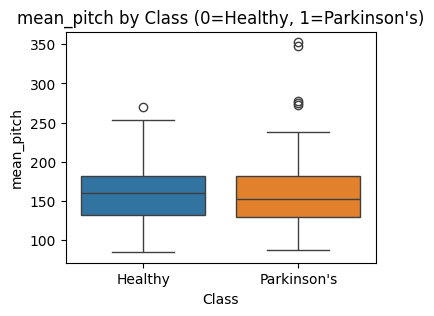

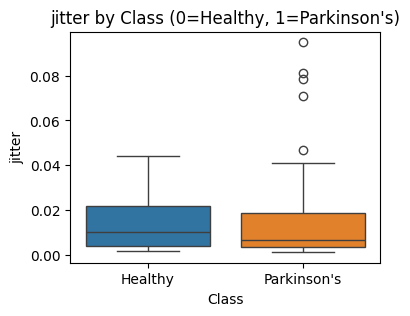

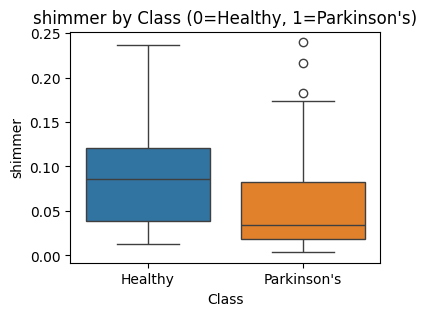

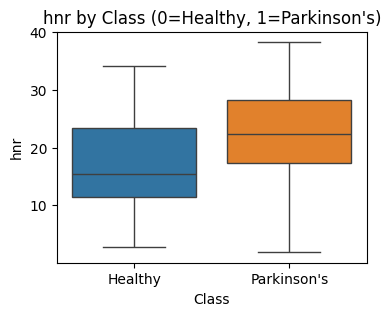

In [34]:
features_to_plot = ['mean_pitch', 'jitter', 'shimmer', 'hnr']

for feature in features_to_plot:
    plt.figure(figsize=(4, 3))
    sns.boxplot(x='label', y=feature, data=features_df, hue='label', legend=False)
    plt.title(f"{feature} by Class (0=Healthy, 1=Parkinson's)")
    plt.xlabel("Class")
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Healthy', 'Parkinson\'s'])


Text(0.5, 1, 'Pairplot of Voice Features')

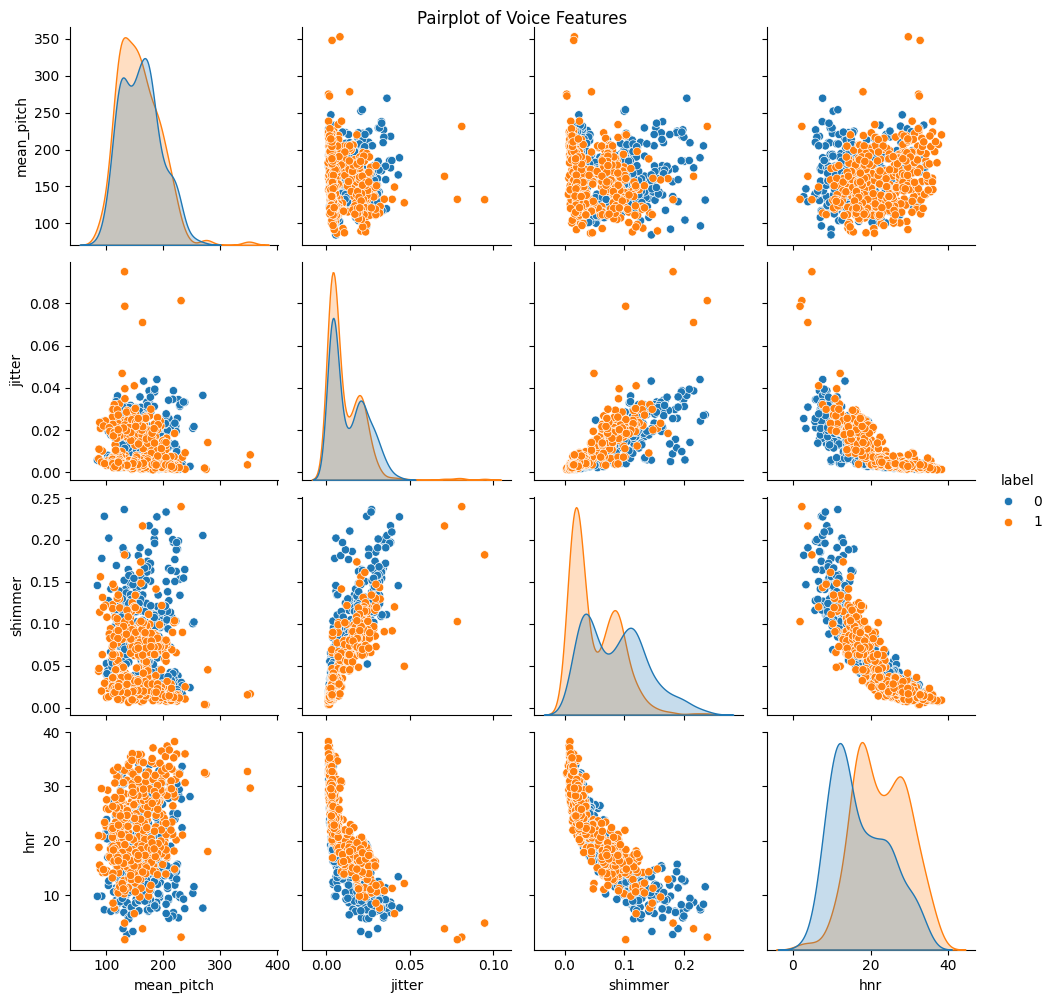

In [35]:
sns.pairplot(features_df, hue='label')
plt.suptitle("Pairplot of Voice Features", y=1)

#### Extracting MFCC

In [36]:
# Load the audio file
y, sr = librosa.load("../raw_data/Italian Parkinson's Voice and Speech/28 People with Parkinson's disease/17-28/Giustina M/FB1GMIAUSST39F100220171206.wav", sr=None)

# Extract MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 is standard, can increase if needed

# Optional: Compute the mean MFCCs across time
mfcc_mean = np.mean(mfcc, axis=1)

print("MFCC shape:", mfcc.shape)       # (n_mfcc, time_frames)
print("MFCC mean:", mfcc_mean.shape)   # (n_mfcc,)

MFCC shape: (13, 2138)
MFCC mean: (13,)


In [76]:
def extract_mfcc(filepath, n_mfcc=13):
    try:
        y, sr = librosa.load(filepath, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        return pd.Series(mfcc_mean, index=[f"mfcc_{i+1}" for i in range(n_mfcc)])
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return pd.Series([np.nan]*n_mfcc, index=[f"mfcc_{i+1}" for i in range(n_mfcc)])

In [ ]:
mfcc_df = df.copy()
mfcc_features = mfcc_df["filepath"].apply(extract_mfcc)
mfcc_df = pd.concat([mfcc_df, mfcc_features], axis=1)

In [39]:
mfcc_df.head()

filepath   subject  \
0  ../raw_data/Italian Parkinson's Voice and Spee...  Davide M   
1  ../raw_data/Italian Parkinson's Voice and Spee...  Davide M   
2  ../raw_data/Italian Parkinson's Voice and Spee...  Davide M   
3  ../raw_data/Italian Parkinson's Voice and Spee...  Biagio P   
4  ../raw_data/Italian Parkinson's Voice and Spee...  Biagio P   

                      group  label      mfcc_1     mfcc_2     mfcc_3  \
0  15 Young Healthy Control      0 -368.630402  84.177010  33.846710   
1  15 Young Healthy Control      0 -414.802948  84.714394  25.441786   
2  15 Young Healthy Control      0 -450.098846  74.961937  24.978941   
3  15 Young Healthy Control      0 -323.156281  78.929321  29.128332   
4  15 Young Healthy Control      0 -311.731750  77.578209  26.185976   

      mfcc_4    mfcc_5     mfcc_6     mfcc_7     mfcc_8    mfcc_9   mfcc_10  \
0  16.814398  9.941368  12.456446   7.952622  11.444529  1.547243  7.135458   
1  17.857388  7.208038  14.077961   8.889725  12.489425  3.273841  8.896996   
2  14.023760  8.403243  14.230879  12.447762  17.047850  6.860118  8.553095   
3  25.235601 -4.947409  17.205950  -3.218043   3.694937 -9.102901  1.509597   
4  26.045549 -4.956986  16.120543  -2.354897   2.328687 -9.865381  2.190332   

    mfcc_11   mfcc_12   mfcc_13  
0  0.412776  2.123266  4.578552  
1 -0.349806  5.019313  2.492667  
2  1.618318  5.099955  4.177287  
3 -4.609385 -1.719794 -8.927525  
4 -5.347436 -1.496885 -8.661850

## Preprocessing pipeline

In [40]:
preprocessor = make_pipeline(RobustScaler())
preprocessor

Pipeline(steps=[('robustscaler', RobustScaler())])

## Defining features (X) and target (y) from features_df

In [41]:
features_df.columns

Index(['mean_pitch', 'jitter', 'shimmer', 'hnr', 'label', 'filename',
       'subject'],
      dtype='object')

In [42]:
#Defining X and y from features_df
X = features_df.drop(columns = ['label', 'filename', 'subject'])
y = features_df.label
print(X.shape)
print(y.shape)

(831, 4)
(831,)


In [43]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)
X_train.head()

(664, 4)
(664,)


mean_pitch    jitter   shimmer        hnr
123  193.408530  0.013619  0.116184   9.606330
144  149.601400  0.005914  0.077537  16.649466
4    117.590166  0.032860  0.108852   8.736543
422  131.882877  0.024597  0.097027  17.249969
197  193.191192  0.002995  0.021350  24.912669

## Models

##### Baseline: Logistic Regression

In [44]:
#Baseline model pipeline
log_reg_pipe = make_pipeline(preprocessor, LogisticRegression())

In [45]:
#Fit baseline model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('logisticregression', LogisticRegression())])

In [46]:
#Evaluate
baseline = log_reg_pipe.score(X_test, y_test)
baseline

0.7544910179640718

##### SVC

In [47]:
#SVC model pipeline
svc_pipe = make_pipeline(preprocessor, SVC())

In [48]:
svc_pipe.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('robustscaler', RobustScaler())])),
  ('svc', SVC())],
 'transform_input': None,
 'verbose': False,
 'pipeline': Pipeline(steps=[('robustscaler', RobustScaler())]),
 'svc': SVC(),
 'pipeline__memory': None,
 'pipeline__steps': [('robustscaler', RobustScaler())],
 'pipeline__transform_input': None,
 'pipeline__verbose': False,
 'pipeline__robustscaler': RobustScaler(),
 'pipeline__robustscaler__copy': True,
 'pipeline__robustscaler__quantile_range': (25.0, 75.0),
 'pipeline__robustscaler__unit_variance': False,
 'pipeline__robustscaler__with_centering': True,
 'pipeline__robustscaler__with_scaling': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc

In [49]:
#Grid search to define the best model parameters
params = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
}

grid_search = GridSearchCV(svc_pipe, params, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('robustscaler',
                                                         RobustScaler())])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.01, 0.1, 1, 10, 100],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
             verbose=1)

In [50]:
#Best parameters
grid_search.best_params_

{'svc__C': 100, 'svc__gamma': 1}

In [51]:
#Best model
best_svc_pipe = grid_search.best_estimator_
best_svc_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('svc', SVC(C=100, gamma=1))])

In [52]:
#Evaluate model
best_svc_pipe.score(X_test, y_test)

0.8562874251497006

In [53]:
#Confusion matrix

y_pred = best_svc_pipe.predict(X_test)

results_df = pd.DataFrame({"actual": y_test, "predicted": y_pred})
confusion_matrix = pd.crosstab(index= results_df['actual'], columns = results_df['predicted'])

print(confusion_matrix)

predicted   0   1
actual           
0          69  10
1          14  74


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        79
           1       0.88      0.84      0.86        88

    accuracy                           0.86       167
   macro avg       0.86      0.86      0.86       167
weighted avg       0.86      0.86      0.86       167



##### Random Forest

In [61]:
#Random forest pipeline
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier())
rf_pipe.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('robustscaler', RobustScaler())])),
  ('randomforestclassifier', RandomForestClassifier())],
 'transform_input': None,
 'verbose': False,
 'pipeline': Pipeline(steps=[('robustscaler', RobustScaler())]),
 'randomforestclassifier': RandomForestClassifier(),
 'pipeline__memory': None,
 'pipeline__steps': [('robustscaler', RobustScaler())],
 'pipeline__transform_input': None,
 'pipeline__verbose': False,
 'pipeline__robustscaler': RobustScaler(),
 'pipeline__robustscaler__copy': True,
 'pipeline__robustscaler__quantile_range': (25.0, 75.0),
 'pipeline__robustscaler__unit_variance': False,
 'pipeline__robustscaler__with_centering': True,
 'pipeline__robustscaler__with_scaling': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_

In [63]:
#Randomized search to define the best model parameters
params = {
    "randomforestclassifier__n_estimators": [50, 100, 200, 300],
    "randomforestclassifier__max_depth": [None, 5, 10, 20, 50],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__bootstrap": [True, False],
}

random_search_rf = RandomizedSearchCV(rf_pipe, params, n_iter=30, cv=5, verbose=1, n_jobs=-1)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('robustscaler',
                                                               RobustScaler())])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [None,
                                                                              5,
                                                                              10,
                                                                              20,
                                                                              50],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 100,
                                                                                 200,
                                                                                 300]},
                   verbose=1)

In [65]:
random_search_rf.best_params_

{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__bootstrap': True}

In [66]:
best_rf_pipe = random_search_rf.best_estimator_
best_rf_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2))])

In [67]:
#Evaluate model
best_rf_pipe.score(X_test, y_test)

0.8682634730538922

In [68]:
#Confusion matrix

y_pred = best_rf_pipe.predict(X_test)

results_df = pd.DataFrame({"actual": y_test, "predicted": y_pred})
confusion_matrix = pd.crosstab(index= results_df['actual'], columns = results_df['predicted'])

print(confusion_matrix)

predicted   0   1
actual           
0          71   8
1          14  74


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        79
           1       0.90      0.84      0.87        88

    accuracy                           0.87       167
   macro avg       0.87      0.87      0.87       167
weighted avg       0.87      0.87      0.87       167



##### CNN with MFCC

In [94]:
#Funtion to extract MFCC
def extract_mfcc_sequence(filepath, n_mfcc=13, max_len=1000):
    try:
        y, sr = librosa.load(filepath, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, time)
        mfcc = mfcc.T  # shape: (time, n_mfcc)

        # Pad or truncate to fixed length
        if mfcc.shape[0] < max_len:
            pad_width = max_len - mfcc.shape[0]
            mfcc_padded = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        else:
            mfcc_padded = mfcc[:max_len, :]

        return mfcc_padded  # shape: (max_len, n_mfcc)
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return np.full((max_len, n_mfcc), np.nan)

In [95]:
#Extract MFCC and create processed dataset

X_mfcc = np.stack(df["filepath"].apply(lambda x: extract_mfcc_sequence(x)).values)
y = df["label"].values

# Add channel dimension for CNN
X_mfcc = np.expand_dims(X_mfcc, axis=-1)  # final shape: (samples, time, n_mfcc, 1)

In [96]:
X_mfcc.shape

(831, 1000, 13, 1)

In [97]:
#Train-test split
X_mfcc_train, X_mfcc_test, y_train, y_test = train_test_split(X_mfcc, y, test_size=0.2, stratify=y, random_state=42)

In [100]:
#Building CNN model

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_mfcc_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 998, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 499, 5, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 497, 3, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 248, 1, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,015,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,753 (3.95 MB)

 Trainable params: 1,034,753 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
#Train model
history = model.fit(
    X_mfcc_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_mfcc_test, y_test),
    verbose=1
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6307 - loss: 16.1105 - val_accuracy: 0.8563 - val_loss: 0.2755
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8695 - loss: 0.2536 - val_accuracy: 0.9042 - val_loss: 0.2031
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9359 - loss: 0.1469 - val_accuracy: 0.9401 - val_loss: 0.1166
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9539 - loss: 0.0920 - val_accuracy: 0.9341 - val_loss: 0.1729
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9463 - loss: 0.1102 - val_accuracy: 0.9162 - val_loss: 0.1908
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9704 - loss: 0.0802 - val_accuracy: 0.9461 - val_loss: 0.1668
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9722 - loss: 0.0809 - val_accuracy: 0.9641 - val_loss: 0.1008
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9847 - loss: 0.0369 - val_accuracy: 0.9461 - 

In [105]:
#Evaluate
test_loss, test_acc = model.evaluate(X_mfcc_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.916167676448822
